<a href="https://colab.research.google.com/github/0thanh2000/44/blob/main/AA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras gym stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 62.7 MB/s eta 0:00:00


# 1. Chuẩn bị dữ liệu
### Đặt file dữ liệu Forex (forex_data.csv) vào Google Drive và sử dụng Google Colab để tải file.

In [ ]:

# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from google.colab import files

# Tải file lên
uploaded = files.upload()

# Đọc file CSV
import pandas as pd
# Đọc file với dấu phân cách là tab và đặt tên cột
data = pd.read_csv('EURUSD60.csv', delimiter='\t', header=None,
                   names=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Chuyển cột 'Time' sang kiểu datetime
data['Time'] = pd.to_datetime(data['Time'])

# Đặt 'Time' làm index (tùy chọn)
data.set_index('Time', inplace=True)

# Kiểm tra lại dữ liệu
print(data.head())

from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá (Open, High, Low, Close)
scaler = MinMaxScaler()
data[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close']])

# Xử lý NaN
data = data.dropna()



Saving EURUSD60.csv to EURUSD60.csv
                        Open     High      Low    Close  Volume
Time                                                           
2009-01-13 06:00:00  1.32575  1.32820  1.32470  1.32515   21886
2009-01-13 07:00:00  1.32515  1.32740  1.32220  1.32725   44867
2009-01-13 08:00:00  1.32730  1.33010  1.32395  1.32500   51227
2009-01-13 09:00:00  1.32500  1.33090  1.32440  1.32935   54489
2009-01-13 10:00:00  1.32935  1.33305  1.32760  1.32935   50811


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa features (4 cột)
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(data[['Open', 'High', 'Low', 'Close']])

# Chuẩn hóa target (cột Close)
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(data[['Close']])

In [ ]:
time_steps = 60  # Sử dụng 60 nến để dự đoán
n_steps = 5      # Dự đoán 5 nến tiếp theo

X, y = [], []
for i in range(len(scaled_features) - time_steps - n_steps + 1):
    # Lấy 60 nến làm đầu vào (từ scaled_features)
    X.append(scaled_features[i:i+time_steps])
    # Lấy 5 giá trị Close tiếp theo (từ scaled_target)
    y.append(scaled_target[i+time_steps : i+time_steps+n_steps].flatten())

X = np.array(X)  # Shape: (samples, 60, 4)
y = np.array(y)  # Shape: (samples, 5)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# In 5 mẫu đầu tiên của X_train và y_train
print("X_train[0]:", X_train[0])
print("y_train[0]:", y_train[0])

X_train[0]: [[0.66362679 0.66658311 0.66360905 0.66259147]
 [0.66255599 0.66515067 0.65913886 0.66633946]
 [0.66639302 0.66998514 0.662268   0.66232376]
 [0.66228829 0.67141757 0.66307263 0.67008745]
 [0.67005158 0.67526724 0.66879448 0.67008745]
 [0.67005158 0.6734767  0.67111898 0.67097983]
 [0.67085467 0.67159663 0.666917   0.66803498]
 [0.66808845 0.6685527  0.65484748 0.6546493 ]
 [0.65461425 0.66031621 0.65359582 0.6579511 ]
 [0.65791587 0.65977905 0.64939384 0.64893807]
 [0.64890332 0.65485506 0.65068126 0.65268606]
 [0.65265112 0.65404931 0.64984086 0.65366768]
 [0.65363268 0.65601891 0.64923291 0.64743887]
 [0.64735067 0.65252735 0.64451239 0.64902731]
 [0.64908179 0.65216924 0.64814219 0.65107978]
 [0.65131262 0.65225877 0.65162894 0.64983045]
 [0.64997412 0.64912532 0.64966205 0.64991969]
 [0.64988489 0.65190066 0.6498945  0.65313225]
 [0.65327575 0.65682465 0.65511569 0.65580939]
 [0.65577428 0.66371824 0.65752959 0.66169909]
 [0.66166366 0.6652402  0.66199979 0.6664287 ]
 

Huấn Luyện Mô Hình

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Thiết lập EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",  # Theo dõi validation loss
    patience=20,          # Dừng nếu loss không giảm sau 5 epochs
    restore_best_weights=True  # Khôi phục trọng số tốt nhất
)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 4)))
model.add(LSTM(50))
model.add(Dense(n_steps))  # Đầu ra 5 giá trị
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],  # Thêm callback EarlyStopping
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0040 - val_loss: 2.2080e-05
Epoch 2/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 6.8436e-05 - val_loss: 2.5118e-05
Epoch 3/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 5.7797e-05 - val_loss: 1.5929e-05
Epoch 4/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.8000e-05 - val_loss: 2.8010e-05
Epoch 5/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.7301e-05 - val_loss: 1.7610e-05
Epoch 6/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 3.8208e-05 - val_loss: 1.0307e-05
Epoch 7/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 3.3811e-05 - val_loss: 1.0209e-05
Epoch 8/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 3.2210e-05 - val_loss: 1.1488e-05
Epoch 9/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 3.2256e-05 - val_loss: 1.2578e-05
Epoch 10/100
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 3.0834e-05 - val_loss: 1.1391e-05
Epoch 11/100
1999/1999 

Bước 5: Dự đoán và chuyển đổi về giá thực

In [ ]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)  # Shape: (samples, 5)

# Inverse transform để lấy giá thực tế
y_pred_actual = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, n_steps)
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, n_steps)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


1. Đánh giá hiệu suất

a. Kiểm tra quá trình huấn luyện

Vẽ đồ thị loss để phát hiện overfitting/underfitting:

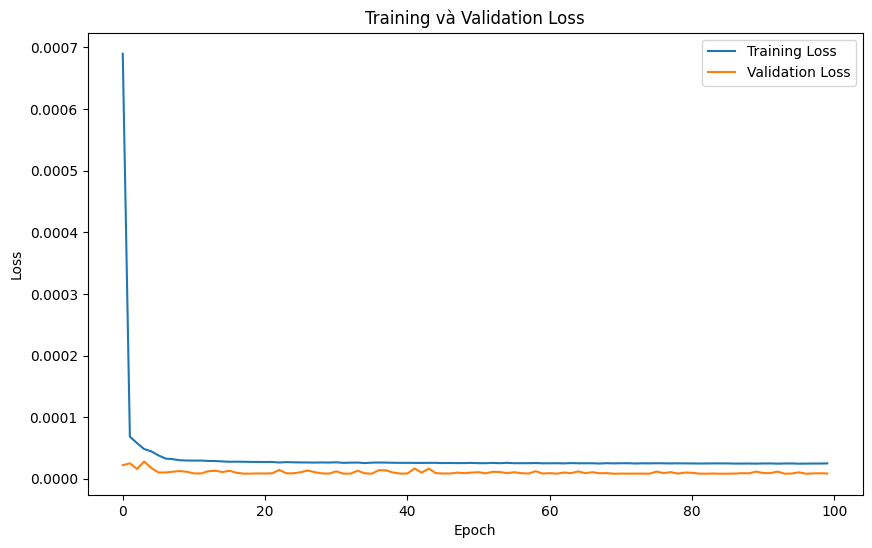

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training và Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

KIỂM TRA KẾT QUẢ

In [ ]:
print("Shape của y_pred_actual:", y_pred_actual.shape)  # (samples, 5)
print("Shape của y_test_actual:", y_test_actual.shape)  # (samples, 5)

Shape của y_pred_actual: (19988, 5)
Shape của y_test_actual: (19988, 5)


 Tính toán các chỉ số đánh giá
RMSE (Root Mean Squared Error): Đánh giá độ lệch chuẩn của dự đoán.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"RMSE: {rmse}")

RMSE: 0.0034607847063854408


MAE (Mean Absolute Error): Đánh giá độ lệch trung bình tuyệt đối.

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"MAE: {mae}")

MAE: 0.002248865774230426


Trực quan hóa kết quả
So sánh giá thực tế và dự đoán:

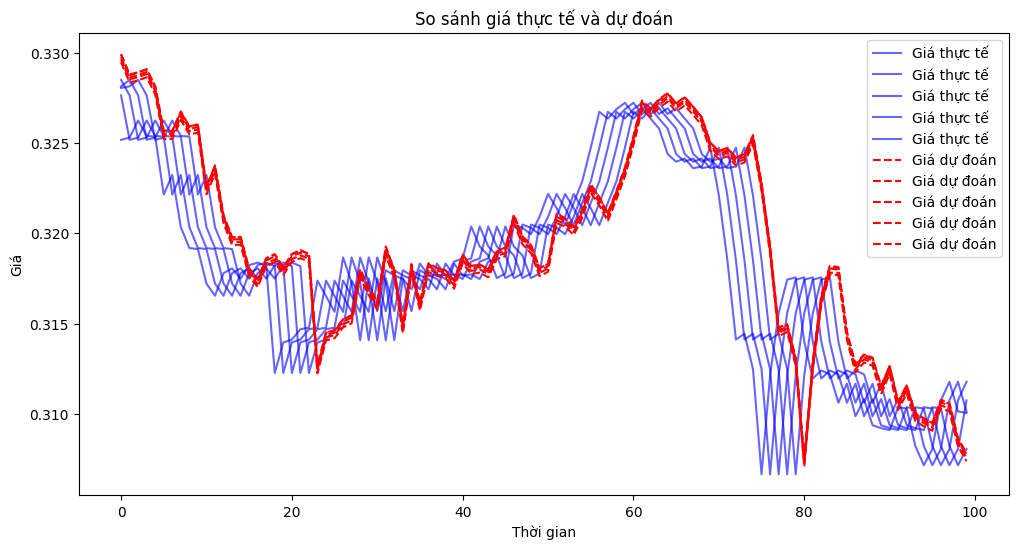

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[100:200], label="Giá thực tế", color="blue", alpha=0.6)
plt.plot(y_pred_actual[100:200], label="Giá dự đoán", color="red", linestyle="--")
plt.title("So sánh giá thực tế và dự đoán")
plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.legend()
plt.show()

Phân phối lỗi:

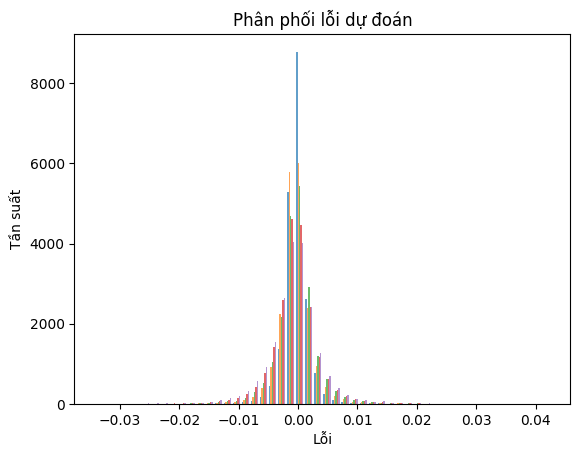

In [ ]:
errors = y_test_actual - y_pred_actual
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Phân phối lỗi dự đoán")
plt.xlabel("Lỗi")
plt.ylabel("Tần suất")
plt.show()

Lưu mô hình

In [ ]:
model.save("forex_lstm_modelT1.keras")  # Lưu cả kiến trúc và trọng số

Tải mô hình để sử dụng sau này

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("forex_lstm_modelT1.keras")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa cột Close
scaler_close = MinMaxScaler()
scaled_close = scaler_close.fit_transform(data[['Close']])

In [ ]:
y_test_actual = scaler_close.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_close.inverse_transform(y_pred.reshape(-1, 1))
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"RMSE trên dữ liệu gốc: {rmse_actual}")

RMSE trên dữ liệu gốc: 0.003460784706385439


In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE trên tập train: {rmse_train}")
print(f"RMSE trên tập test: {rmse_test}")

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
RMSE trên tập train: 0.0045514618042912245
RMSE trên tập test: 0.0034607847063854408


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model  # Sửa lại import

# Định nghĩa hàm preprocess_data trong cùng file
def preprocess_data(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[["Close"]])
    return scaled_data, scaler

# Load model từ file .keras
model = load_model("forex_lstm_modelT1.keras")  # Đảm bảo đường dẫn đúng

# Tiêu đề ứng dụng
st.title("Dự đoán giá Forex- USDCHF")

# ... Phần còn lại của code Streamlit

# Tải lên dữ liệu
uploaded_file = st.file_uploader("USDCHF60", type=["csv"])
if uploaded_file is not None:
    data = pd.read_csv(uploaded_file)

    # Tiền xử lý dữ liệu
    scaled_data, scaler = preprocess_data(data)
    X = create_sequences(scaled_data, time_steps=60)  # Hàm tạo chuỗi dữ liệu

    # Dự đoán
    predictions = model.predict(X)
    predictions_actual = scaler.inverse_transform(predictions)

    # Hiển thị kết quả
    st.subheader("Dự đoán 5 nến tiếp theo:")
    st.write(predictions_actual[-5:])

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(data["Close"], label="Giá thực tế")
    plt.plot(np.arange(len(data)-5, len(data)), predictions_actual[-5:], "ro-", label="Dự đoán")
    plt.legend()
    st.pyplot(plt)
else:
    st.write("Vui lòng tải lên file CSV chứa dữ liệu giá EUR/USD.")

ModuleNotFoundError: No module named 'streamlit'